In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline
warnings.filterwarnings("ignore")
import datetime

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


jointure entre les tables 

In [2]:
vols= pd.read_csv("./vols.csv")
aeroports= pd.read_csv("./aeroports.csv")
compagnies= pd.read_csv("./compagnies.csv")

origin_aeroports = aeroports.rename(columns={'CODE IATA':'AEROPORT DEPART','NOM': 'ORIGIN_AIRPORT',
                                        'LIEU':'ORIGIN_LIEU','PAYS':'ORIGIN_PAYS','LONGITUDE':'ORIGIN_LONGITUDE',
                                        'LATITUDE':'ORIGIN_LATITUDE','HAUTEUR':'ORIGIN_HAUTEUR',
                                        'PRIX RETARD PREMIERE 10 MINUTES':'ORIGIN_PRIX RETARD PREMIERE 10 MINUTES',
                                        'PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES':'ORIGIN_PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES'})
destination_aeroports = aeroports.rename(columns={'CODE IATA':'AEROPORT ARRIVEE','NOM': 'DESTINATION_AIRPORT',
                                         'LIEU':'DESTINATION_LIEU','PAYS':'DESTINATION_PAYS','LONGITUDE':'DESTINATION_LONGITUDE',
                                         'LATITUDE':'DESTINATION_LATITUDE','HAUTEUR':'DESTINATION_HAUTEUR',
                                         'PRIX RETARD PREMIERE 10 MINUTES':'DESTINATION_PRIX RETARD PREMIERE 10 MINUTES',
                                         'PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES':'DESTINATION_PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES'})
del origin_aeroports['index']
del destination_aeroports['index']
del compagnies['index']

vols = pd.merge(vols, origin_aeroports, how= 'left', left_on='AEROPORT DEPART', right_on='AEROPORT DEPART')
vols = pd.merge(vols, destination_aeroports, how= 'left', left_on='AEROPORT ARRIVEE', right_on='AEROPORT ARRIVEE')
vols = pd.merge(vols, compagnies,  how='left', left_on='COMPAGNIE AERIENNE', right_on='CODE')
del vols['CODE']


In [3]:
vols

,index,IDENTIFIANT,VOL,CODE AVION,AEROPORT DEPART,AEROPORT ARRIVEE,DEPART PROGRAMME,HEURE DE DEPART,RETART DE DEPART,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,...,ORIGIN_PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES,DESTINATION_AIRPORT,DESTINATION_LIEU,DESTINATION_PAYS,DESTINATION_LONGITUDE,DESTINATION_LATITUDE,DESTINATION_HAUTEUR,DESTINATION_PRIX RETARD PREMIERE 10 MINUTES,DESTINATION_PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES,COMPAGNIE
0,0,651373,2317,28fa5df4d7,TIA,DSS,1410,1411.0,1.0,20.0,...,586,Blaise Diagne International Airport,Dakar,SN,-17.073333,14.670000,290.0,5499,120,Ne Va Pas Partout Airlines
1,1,4153042,1755,4b31cd6358,MPM,BOH,1455,1449.0,-6.0,15.0,...,12,Bournemouth Airport,Bournemouth,GB,-1.842500,50.779999,38.0,3147,278,Corporate Overlord Airways
2,2,3617513,804,f3e0769c08,TRN,TNA,1540,1607.0,27.0,9.0,...,849,Yaoqiang Airport,Jinan,CN,117.216003,36.857201,76.0,2066,795,Neverland Airlines
3,3,1829601,263,2ba258e5c4,BRU,SXF,2226,2219.0,-7.0,14.0,...,48,Berlin-SchÃ¶nefeld Airport,Berlin,DE,13.522500,52.380001,157.0,2151,685,Try Hard Airlines
4,4,1250864,4511,11e7ffe99f,VCE,AAL,1730,1719.0,-11.0,14.0,...,434,Aalborg Airport,Aalborg,DK,9.849243,57.092759,10.0,8346,353,Morally Ambiguious Fligthts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3279285,2999995,782415,769,eb935c21e5,AGP,GOI,2216,2216.0,0.0,16.0,...,143,Dabolim Airport,Vasco da Gama,IN,73.831398,15.380800,150.0,8381,919,Ne Va Pas Partout Airlines
3279286,2999996,2046281,1233,208b41519d,DUR,MPM,1318,1316.0,-2.0,12.0,...,823,Maputo Airport,Maputo,MZ,32.572601,-25.920799,145.0,4778,12,Try Hard Airlines
3279287,2999997,1996895,323,770ec5ae7b,BOH,HAN,755,756.0,1.0,13.0,...,278,Noi Bai International Airport,Hanoi,VN,105.806999,21.221201,39.0,8379,693,Try Hard Airlines
3279288,2999998,5294861,3626,5babf41084,DXB,PMI,1648,1720.0,32.0,17.0,...,848,Palma De Mallorca Airport,Palma De Mallorca,ES,2.738810,39.551701,27.0,902,411,Bel Air


### Dealing with with Na values 

In [4]:
vols.isna().sum()

index                                                                0
IDENTIFIANT                                                          0
VOL                                                                  0
CODE AVION                                                           0
AEROPORT DEPART                                                      0
AEROPORT ARRIVEE                                                     0
DEPART PROGRAMME                                                     0
HEURE DE DEPART                                                  51414
RETART DE DEPART                                                 51414
TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE                        53406
DECOLLAGE                                                        53406
TEMPS PROGRAMME                                                      6
TEMPS PASSE                                                      62529
TEMPS DE VOL                                                     62529
DISTAN

In [5]:
# drop column big amount NA values
vols = vols[vols.columns.difference(["RAISON D'ANNULATION", 'RETARD SYSTEM', 'RETARD SECURITE',
                                              'RETARD AVION', 'RETARD COMPAGNIE', 'RETARD METEO'])]

In [6]:
"""""""""""""""
print('Dataframe dimensions:', df.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values

tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info
"""""""""""""""
vols.isna().sum()

AEROPORT ARRIVEE                                                    0
AEROPORT DEPART                                                     0
ANNULATION                                                          0
ARRIVEE PROGRAMMEE                                                  0
ATTERRISSAGE                                                    55336
CODE AVION                                                          0
COMPAGNIE                                                           0
COMPAGNIE AERIENNE                                             223233
DATE                                                                0
DECOLLAGE                                                       53406
DEPART PROGRAMME                                                    0
DESTINATION_AIRPORT                                                 0
DESTINATION_HAUTEUR                                                 0
DESTINATION_LATITUDE                                                0
DESTINATION_LIEU    

In [7]:
# drop NA values
vols = vols.dropna() #After dropping certian columns, we drop lines with NA values. There are just a few lines, not representative.

In [17]:
vols.isna().sum()

AEROPORT ARRIVEE                                               0
AEROPORT DEPART                                                0
ANNULATION                                                     0
ARRIVEE PROGRAMMEE                                             0
ATTERRISSAGE                                                   0
CODE AVION                                                     0
COMPAGNIE                                                      0
COMPAGNIE AERIENNE                                             0
DATE                                                           0
DECOLLAGE                                                      0
DEPART PROGRAMME                                               0
DESTINATION_AIRPORT                                            0
DESTINATION_HAUTEUR                                            0
DESTINATION_LATITUDE                                           0
DESTINATION_LIEU                                               0
DESTINATION_LONGITUDE    

In [8]:
len(vols)
print('There are %d flights in dataset' % len(vols))
vols.shape

There are 2997544 flights in dataset


(2997544, 42)

In [9]:
vols.head(5)

,AEROPORT ARRIVEE,AEROPORT DEPART,ANNULATION,ARRIVEE PROGRAMMEE,ATTERRISSAGE,CODE AVION,COMPAGNIE,COMPAGNIE AERIENNE,DATE,DECOLLAGE,...,ORIGIN_PRIX RETARD PREMIERE 10 MINUTES,RETARD A L'ARRIVEE,RETART DE DEPART,TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,TEMPS DE VOL,TEMPS PASSE,TEMPS PROGRAMME,VOL,index
0,DSS,TIA,0,2059,2048.0,28fa5df4d7,Ne Va Pas Partout Airlines,NVPPA,10/4/2016,1431.0,...,4582,-1.0,1.0,10.0,20.0,197.0,227.0,229.0,2317,0
1,BOH,MPM,0,1925,1857.0,4b31cd6358,Corporate Overlord Airways,COA,16/7/2018,1504.0,...,4778,-25.0,-6.0,3.0,15.0,173.0,191.0,210.0,1755,1
3,SXF,BRU,0,2350,2323.0,2ba258e5c4,Try Hard Airlines,THA,9/1/2016,2233.0,...,5077,-22.0,-7.0,5.0,14.0,50.0,69.0,84.0,263,3
4,AAL,VCE,0,1841,1818.0,11e7ffe99f,Morally Ambiguious Fligthts,MAF,23/1/2016,1733.0,...,2143,-16.0,-11.0,7.0,14.0,45.0,66.0,71.0,4511,4
5,DXB,DUR,0,1317,1307.0,fe17bac29e,Corporate Overlord Airways,COA,14/4/2016,1010.0,...,5737,0.0,-7.0,10.0,22.0,237.0,269.0,262.0,1238,5


### cleaning

Spliter la date en JOUR/MOIS/ANNEE

In [10]:
from datetime import datetime
# the date 
# Make a copy of the original data to avoid writing on the original data
df = vols.copy()

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
df['DateOfDeparture'] = pd.to_datetime(df['DATE'])
df['ANNEE'] = df['DateOfDeparture'].dt.year
df['MOIS'] = df['DateOfDeparture'].dt.month
df['JOUR'] = df['DateOfDeparture'].dt.day

Cnvertire les colonnes qui représente le temps en format HH:MM:SS

In [35]:
from datetime import datetime
#_____________________________________________________
# Function that convert the 'HHMM' string to datetime.time  
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________

In [ ]:
df['DEPART PROGRAMME'] = df['DEPART PROGRAMME'].apply(format_heure)
df['HEURE DE DEPART'] = df['HEURE DE DEPART'].apply(format_heure)
df['ARRIVEE PROGRAMMEE'] = df['ARRIVEE PROGRAMMEE'].apply(format_heure)
df["HEURE D'ARRIVEE"] = df["HEURE D'ARRIVEE"].apply(format_heure)
##
#__________________________________________________________________________
df.loc[:5, ['DEPART PROGRAMME', 'ARRIVEE PROGRAMMEE', 'HEURE DE DEPART',
             "HEURE D'ARRIVEE", 'RETART DE DEPART', "RETARD A L'ARRIVEE"]]

In [11]:
df.dtypes

AEROPORT ARRIVEE                                                       object
AEROPORT DEPART                                                        object
ANNULATION                                                              int64
ARRIVEE PROGRAMMEE                                                      int64
ATTERRISSAGE                                                          float64
CODE AVION                                                             object
COMPAGNIE                                                              object
COMPAGNIE AERIENNE                                                     object
DATE                                                                   object
DECOLLAGE                                                             float64
DEPART PROGRAMME                                                        int64
DESTINATION_AIRPORT                                                    object
DESTINATION_HAUTEUR                                             

### Descriptive Analysis / Exploratory Analysis

##### statistique des sur les compagnies aérienne

In [12]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['RETART DE DEPART'].groupby(df['COMPAGNIE AERIENNE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
COMPAGNIE AERIENNE,,,,
BTATA,-24.0,644.0,40139.0,9.181370
AP,-27.0,1433.0,51128.0,0.624804
AAPF,-46.0,996.0,64261.0,14.317160
APSLM,-35.0,836.0,78258.0,16.468259
FIPI,-82.0,963.0,119255.0,1.862580
OA,-26.0,1006.0,174731.0,11.860059
SMITH,-36.0,1278.0,186921.0,10.524452
THA,-24.0,1314.0,347795.0,14.929375
I6F,-55.0,1236.0,371833.0,8.955644


Pour bien illustrer le tableau ci dessus

In [13]:
abbr_companies = df.set_index('COMPAGNIE AERIENNE')['COMPAGNIE'].to_dict()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


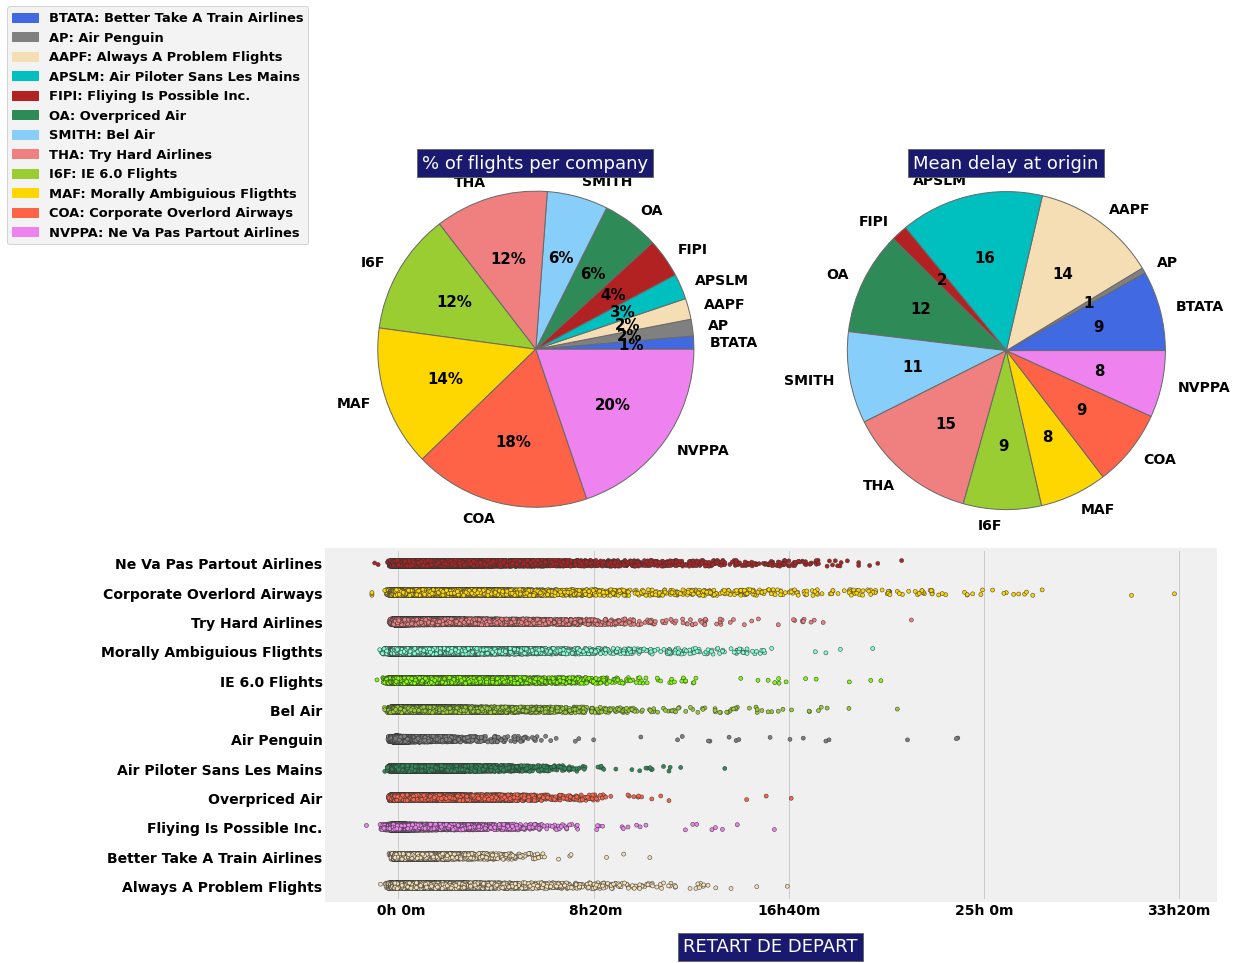

In [14]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['COMPAGNIE AERIENNE', 'RETART DE DEPART']]
df2['COMPAGNIE AERIENNE'] = df2['COMPAGNIE AERIENNE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse','orange']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights 
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue','orange']
# IL FAUT AVOIR LES MEME COULEUR POUR LES 2 GRAPHS
#___________________________________________________________________
ax3 = sns.stripplot(y="COMPAGNIE AERIENNE", x="RETART DE DEPART", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('RETART DE DEPART', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 


In [15]:
abbr_companies

{'NVPPA': 'Ne Va Pas Partout Airlines',
 'COA': 'Corporate Overlord Airways',
 'THA': 'Try Hard Airlines',
 'MAF': 'Morally Ambiguious Fligthts',
 'I6F': 'IE 6.0 Flights',
 'SMITH': 'Bel Air',
 'AP': 'Air Penguin',
 'APSLM': 'Air Piloter Sans Les Mains',
 'OA': 'Overpriced Air',
 'FIPI': 'Fliying Is Possible Inc.',
 'BTATA': 'Better Take A Train Airlines',
 'AAPF': 'Always A Problem Flights'}

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


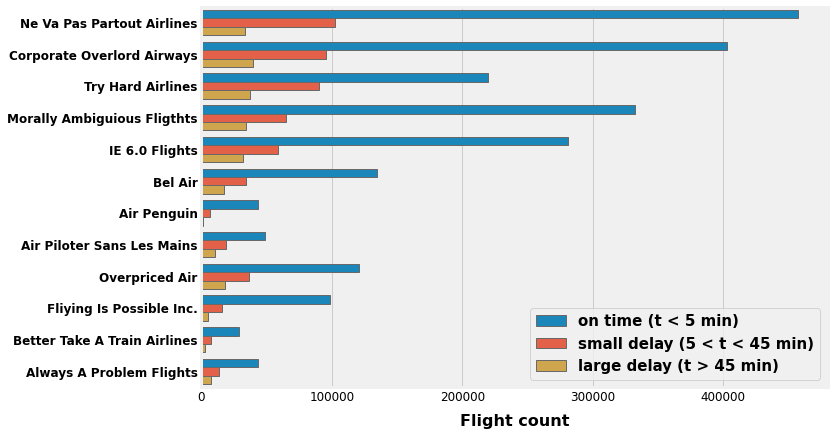

In [16]:
#___________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['RETART DE DEPART'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="COMPAGNIE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = df["COMPAGNIE"].unique()
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

### Retard : à l'arrivée ou du départ ?

In [26]:
df["COMPAGNIE"].unique()

array(['Ne Va Pas Partout Airlines', 'Corporate Overlord Airways',
       'Try Hard Airlines', 'Morally Ambiguious Fligthts',
       'IE 6.0 Flights', 'Bel Air', 'Air Penguin',
       'Air Piloter Sans Les Mains', 'Overpriced Air',
       'Fliying Is Possible Inc.', 'Better Take A Train Airlines',
       'Always A Problem Flights'], dtype=object)

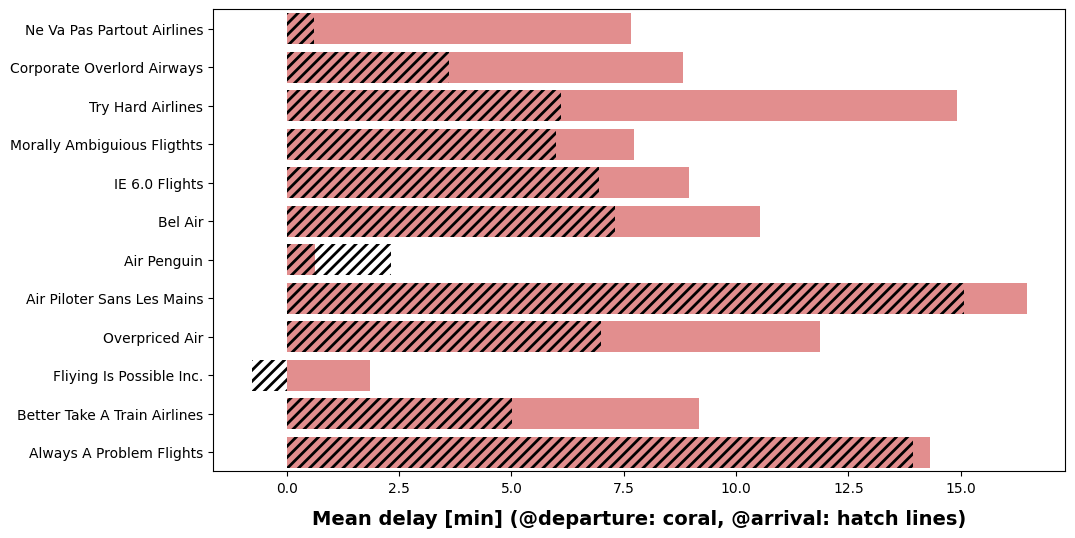

In [17]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="RETART DE DEPART", y="COMPAGNIE", data=df, color="lightcoral", ci=None)
ax = sns.barplot(x="RETARD A L'ARRIVEE", y="COMPAGNIE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = df["COMPAGNIE"].unique()
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: coral, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

### le nombre d'aéroports de destination/visités pour chaque compagnie aérienne ?

In [28]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['COMPAGNIE AERIENNE'] == carrier]['AEROPORT DEPART'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

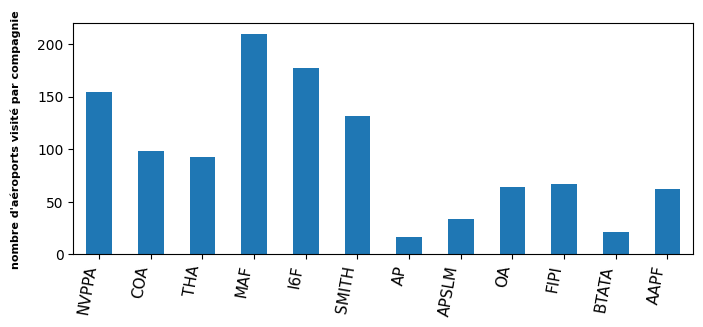

In [29]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = df['COMPAGNIE AERIENNE'].unique()
ax.set_xticklabels(labels)
plt.ylabel("nombre d'aéroports visité par compagnie", fontsize=8, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

### comment l'aéroport d'origine/depart impact les retards de depart?

In [159]:
airport_mean_delays = pd.DataFrame(pd.Series(df['AEROPORT DEPART'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['COMPAGNIE AERIENNE'] == carrier]
    test = df1['RETART DE DEPART'].groupby(df['AEROPORT DEPART']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 


In [168]:
temp = pd.read_csv('./aeroports.csv')
identify_airport = temp.set_index('CODE IATA')['LIEU'].to_dict()

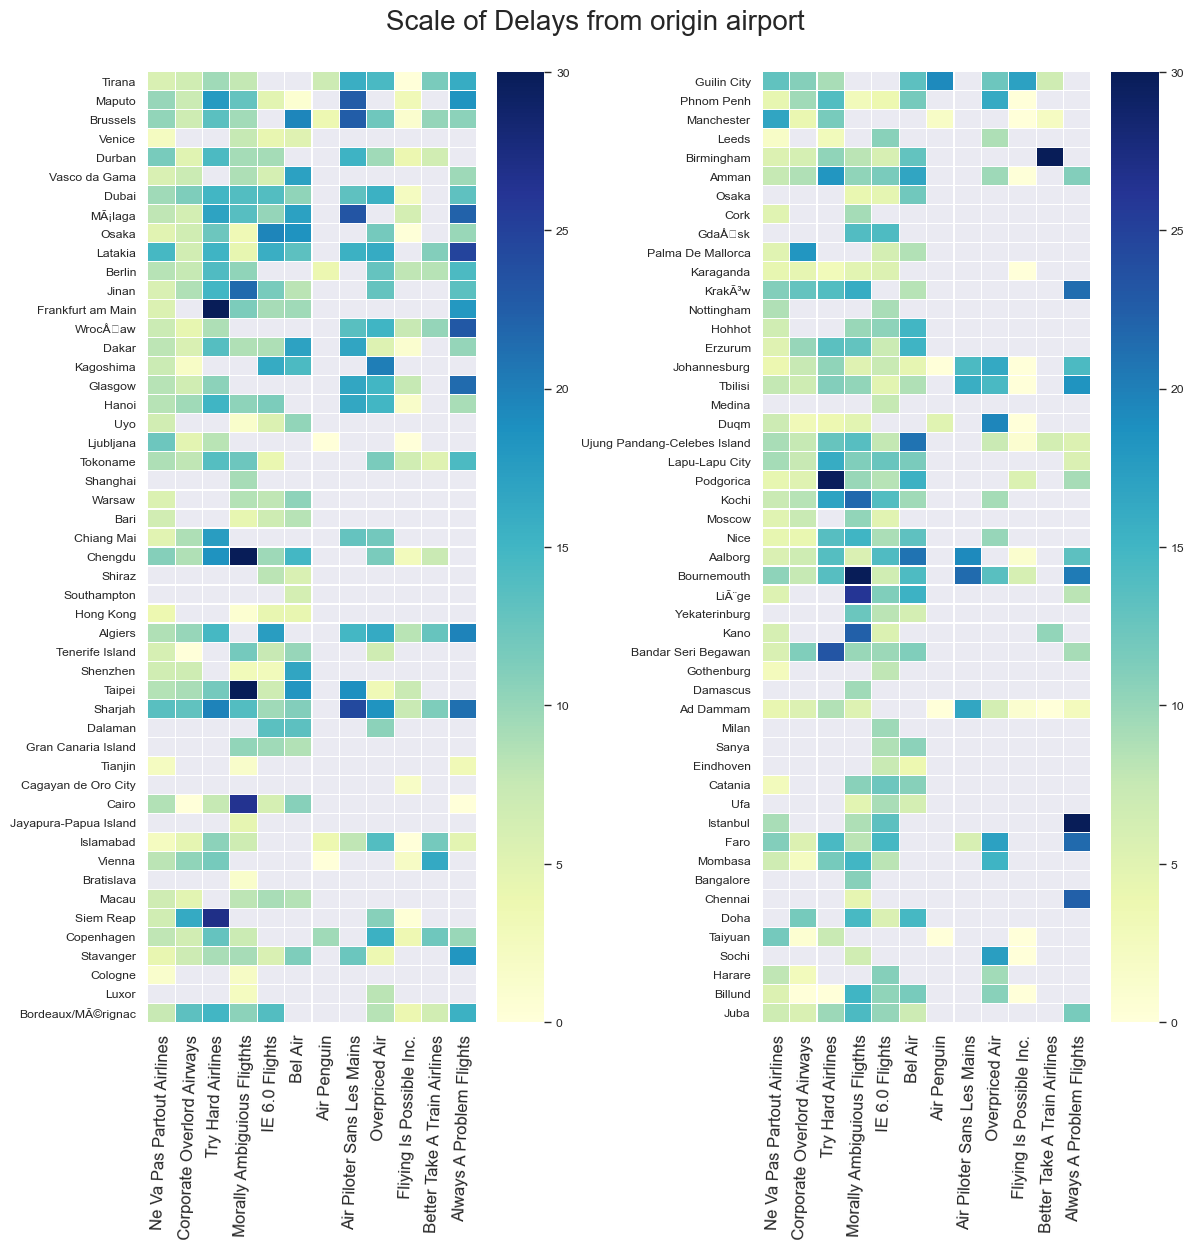

In [169]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(12,12))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.05, cmap="YlGnBu", mask=mask, vmin = 0, vmax = 30)
plt.setp(ax.get_xticklabels(), fontsize=12, rotation = 88) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Scale of Delays from origin airport", ha='center', fontsize = 20)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.05, cmap="YlGnBu", mask=mask, vmin = 0, vmax = 30)
plt.setp(ax.get_xticklabels(), fontsize=12, rotation = 88) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

#### Variation dans le temps des retards de depart 

In [44]:
df["ANNEE"].unique()

array([2016, 2018, 2017])

<Figure size 1500x500 with 0 Axes>

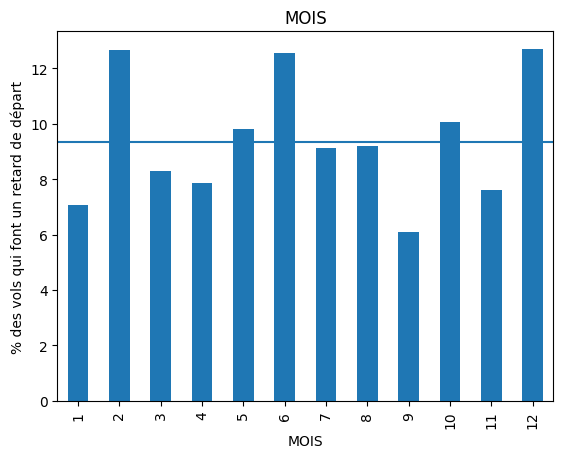

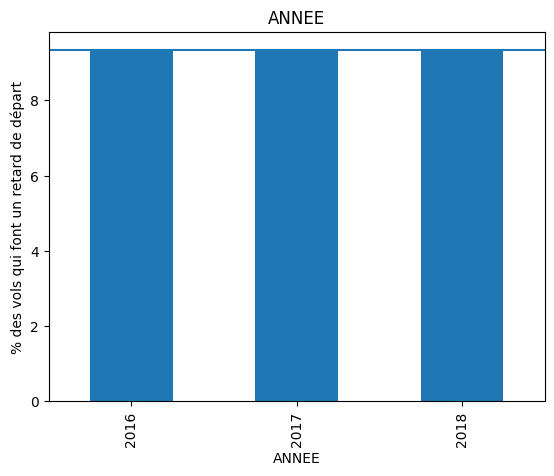

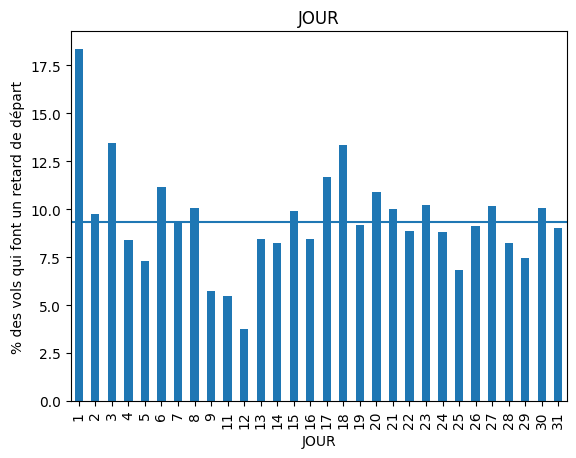

In [45]:
# Proportion of late flights per category based on all other flights

avgLate = np.sum(df['RETART DE DEPART'])/len(df['RETART DE DEPART'])
attributes = ['MOIS','ANNEE','JOUR']
for i,pred in enumerate(attributes):
    plt.figure(i, figsize=(15, 5))
    group = df.groupby([pred], as_index=False).aggregate(np.mean)[[pred, 'RETART DE DEPART']]
    group.sort_values(by=pred, inplace=True)    
    group.plot.bar(x=pred, y='RETART DE DEPART')
    plt.axhline(y=avgLate, label='Average')
    plt.ylabel('% des vols qui font un retard de départ')
    plt.title(pred)
    plt.legend().remove()

### Feature enginireeng or Feature selection

##### Selecting the columns that we will be working with

In [95]:
df_vols = df[['AEROPORT ARRIVEE','AEROPORT DEPART','ARRIVEE PROGRAMMEE',
        'COMPAGNIE AERIENNE', 'ANNEE', 'MOIS','JOUR',
        'DEPART PROGRAMME', "DISTANCE",
        'RETART DE DEPART']]
df_vols[:5]

,AEROPORT ARRIVEE,AEROPORT DEPART,ARRIVEE PROGRAMMEE,COMPAGNIE AERIENNE,ANNEE,MOIS,JOUR,DEPART PROGRAMME,DISTANCE,RETART DE DEPART
0,DSS,TIA,2059,NVPPA,2016,10,4,1410,1749,1.0
1,BOH,MPM,1925,COA,2018,7,16,1455,1325,-6.0
3,SXF,BRU,2350,THA,2016,9,1,2226,337,-7.0
4,AAL,VCE,1841,MAF,2016,1,23,1730,252,-11.0
5,DXB,DUR,1317,COA,2016,4,14,955,1562,-7.0


In [96]:
df_vols['Dep_retard15']=df_vols['RETART DE DEPART'].apply(lambda x:1 if x > 15 else 0)

In [97]:
df_vols.groupby('Dep_retard15').size()

Dep_retard15
0    2474658
1     522886
dtype: int64

In [99]:
df_vols = df_vols.drop(['RETART DE DEPART'], axis=1)

In [100]:
df_vols

,AEROPORT ARRIVEE,AEROPORT DEPART,ARRIVEE PROGRAMMEE,COMPAGNIE AERIENNE,ANNEE,MOIS,JOUR,DEPART PROGRAMME,DISTANCE,Dep_retard15
0,DSS,TIA,2059,NVPPA,2016,10,4,1410,1749,0
1,BOH,MPM,1925,COA,2018,7,16,1455,1325,0
3,SXF,BRU,2350,THA,2016,9,1,2226,337,0
4,AAL,VCE,1841,MAF,2016,1,23,1730,252,0
5,DXB,DUR,1317,COA,2016,4,14,955,1562,0
...,...,...,...,...,...,...,...,...,...,...
3279285,GOI,AGP,2326,NVPPA,2018,3,30,2216,669,0
3279286,MPM,DUR,1647,THA,2016,2,12,1318,1597,0
3279287,HAN,BOH,1020,THA,2018,10,2,755,1558,0
3279288,PMI,DXB,1839,SMITH,2016,6,27,1648,604,1


##### dealing with catégorial features and numurical features

In [101]:
#lets check the numerical columns:
cols_num = ['ARRIVEE PROGRAMMEE','ANNEE','MOIS','JOUR','DEPART PROGRAMME','DISTANCE']
cols_num

['ARRIVEE PROGRAMMEE', 'ANNEE', 'MOIS', 'JOUR', 'DEPART PROGRAMME', 'DISTANCE']

In [102]:
df_vols[cols_num].isnull().sum()

ARRIVEE PROGRAMMEE    0
ANNEE                 0
MOIS                  0
JOUR                  0
DEPART PROGRAMME      0
DISTANCE              0
dtype: int64

In [103]:
#categorial features :  
cols_cat = ['AEROPORT ARRIVEE','AEROPORT DEPART','COMPAGNIE AERIENNE']
cols_cat

['AEROPORT ARRIVEE', 'AEROPORT DEPART', 'COMPAGNIE AERIENNE']

In [104]:
#check the unique values:
df_vols[cols_cat].nunique()

AEROPORT ARRIVEE      318
AEROPORT DEPART       318
COMPAGNIE AERIENNE     12
dtype: int64

In [105]:
df_vols[cols_cat].isnull().sum()

AEROPORT ARRIVEE      0
AEROPORT DEPART       0
COMPAGNIE AERIENNE    0
dtype: int64

Dans le one-hot encoding, nous créons une nouvelle colonne pour chaque valeur unique dans cette colonne. La valeur de la colonne est alors 1 si l'échantillon a cette valeur unique ou 0 sinon. Par exemple, pour la colonne COMPAGNIE AERIENNE, nous créerions de nouvelles colonnes ('COMPAGNIE AERIENNE_AS', 'COMPAGNIE AERIENNE _B6', etc.). Si la compagnie aérienne est AS, le vol obtient un 1 sous «COMPAGNIE AERIENNE_AS» et 0 sous le reste des colonnes COMPAGNIE AERIENNE . Pour créer ces colonnes d'encodage à chaud, nous pouvons utiliser la fonction get_dummies. J'ai utilisé l'option de préfixe afin que nous puissions remonter à la colonne d'origine.

In [106]:
pd.get_dummies(df[cols_cat],drop_first = True).head()

,AEROPORT ARRIVEE_AAP,AEROPORT ARRIVEE_ABV,AEROPORT ARRIVEE_ACC,AEROPORT ARRIVEE_ADB,AEROPORT ARRIVEE_ADD,AEROPORT ARRIVEE_AER,AEROPORT ARRIVEE_AGP,AEROPORT ARRIVEE_AKT,AEROPORT ARRIVEE_ALA,AEROPORT ARRIVEE_ALC,...,COMPAGNIE AERIENNE_APSLM,COMPAGNIE AERIENNE_BTATA,COMPAGNIE AERIENNE_COA,COMPAGNIE AERIENNE_FIPI,COMPAGNIE AERIENNE_I6F,COMPAGNIE AERIENNE_MAF,COMPAGNIE AERIENNE_NVPPA,COMPAGNIE AERIENNE_OA,COMPAGNIE AERIENNE_SMITH,COMPAGNIE AERIENNE_THA
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [108]:
df_cat = pd.get_dummies(df[cols_cat],drop_first = True)

In [109]:
df_vols = pd.concat([df_vols,df_cat], axis = 1)
df_vols

,AEROPORT ARRIVEE,AEROPORT DEPART,ARRIVEE PROGRAMMEE,COMPAGNIE AERIENNE,ANNEE,MOIS,JOUR,DEPART PROGRAMME,DISTANCE,Dep_retard15,...,COMPAGNIE AERIENNE_APSLM,COMPAGNIE AERIENNE_BTATA,COMPAGNIE AERIENNE_COA,COMPAGNIE AERIENNE_FIPI,COMPAGNIE AERIENNE_I6F,COMPAGNIE AERIENNE_MAF,COMPAGNIE AERIENNE_NVPPA,COMPAGNIE AERIENNE_OA,COMPAGNIE AERIENNE_SMITH,COMPAGNIE AERIENNE_THA
0,DSS,TIA,2059,NVPPA,2016,10,4,1410,1749,0,...,0,0,0,0,0,0,1,0,0,0
1,BOH,MPM,1925,COA,2018,7,16,1455,1325,0,...,0,0,1,0,0,0,0,0,0,0
3,SXF,BRU,2350,THA,2016,9,1,2226,337,0,...,0,0,0,0,0,0,0,0,0,1
4,AAL,VCE,1841,MAF,2016,1,23,1730,252,0,...,0,0,0,0,0,1,0,0,0,0
5,DXB,DUR,1317,COA,2016,4,14,955,1562,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3279285,GOI,AGP,2326,NVPPA,2018,3,30,2216,669,0,...,0,0,0,0,0,0,1,0,0,0
3279286,MPM,DUR,1647,THA,2016,2,12,1318,1597,0,...,0,0,0,0,0,0,0,0,0,1
3279287,HAN,BOH,1020,THA,2018,10,2,755,1558,0,...,0,0,0,0,0,0,0,0,0,1
3279288,PMI,DXB,1839,SMITH,2016,6,27,1648,604,1,...,0,0,0,0,0,0,0,0,1,0


In [110]:
cols_all_cat = list(df_cat.columns)
print('number of categorical:',len(cols_all_cat))

number of categorical: 645


Let's make a new dataframe that only has the **columns of interest**

In [112]:
cols_input = cols_num + cols_all_cat
df_data = df_vols[cols_input + ['Dep_retard15']]
df_data.head()
#0 4 5

,ARRIVEE PROGRAMMEE,ANNEE,MOIS,JOUR,DEPART PROGRAMME,DISTANCE,AEROPORT ARRIVEE_AAP,AEROPORT ARRIVEE_ABV,AEROPORT ARRIVEE_ACC,AEROPORT ARRIVEE_ADB,...,COMPAGNIE AERIENNE_BTATA,COMPAGNIE AERIENNE_COA,COMPAGNIE AERIENNE_FIPI,COMPAGNIE AERIENNE_I6F,COMPAGNIE AERIENNE_MAF,COMPAGNIE AERIENNE_NVPPA,COMPAGNIE AERIENNE_OA,COMPAGNIE AERIENNE_SMITH,COMPAGNIE AERIENNE_THA,Dep_retard15
0,2059,2016,10,4,1410,1749,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1925,2018,7,16,1455,1325,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2350,2016,9,1,2226,337,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1841,2016,1,23,1730,252,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,1317,2016,4,14,955,1562,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


####  Building Training/Validation/Test Samples
Jusqu'à présent, nous avons exploré nos données et créé des variables à partir des données catégorielles. Il est maintenant temps pour diviser nos données. L'idée derrière le fractionnement des données est de pouvoir mesurer la performance de notre modèle sur des données invisibles. Nous les avons divisés en trois parties:

- Échantillons d'apprentissage: ces échantillons sont utilisés pour former le modèle
- Échantillons de validation: ces échantillons sont extraits des données de formation et sont utilisés pour prendre des décisions sur la façon d'améliorer le modèle
- Échantillons de test: ces échantillons sont tenus à l'écart de toutes les décisions et sont utilisés pour mesurer les performances généralisées du modèle


Dans ce projet, nous nous répartirons en 70% de train, 15% de validation, 15% de test.

La première chose que j'aime faire est de mélanger les échantillons en utilisant l'échantillon au cas où il y aurait un ordre (par exemple, tous les échantillons positifs sur le dessus). Ici n est le nombre.

In [113]:
#shuffle the samples
df_data = df_data.sample(n = len(df_data))
df_data = df_data.reset_index(drop = True)

Nous pouvons à nouveau utiliser notre sample pour extraire 30% (en utilisant frac) des données à utiliser pour la validation / test des divisions. Il est important que la validation et le test proviennent de distributions similaires et cette technique est un moyen de le faire.

In [114]:
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


Et maintenant en divise en test et validation en utilisant une fraction de 50%.

In [115]:
#now split into test and validation using 50% fraction
df_test = df_valid_test.sample(frac = 0.5)
df_valid = df_valid_test.drop(df_test.index)

.drop supprime simplement les lignes de df_test pour obtenir les lignes qui ne faisaient pas partie de l'échantillon. Nous pouvons utiliser cette même idée pour obtenir les données de train.

In [116]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

À ce stade, vérifions le pourcentage de nos groupes qui ont un retard de départ. C'est ce qu'on appelle la prévalence. Idéalement, les trois groupes auraient une prévalence similaire

In [117]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [118]:
print('Prevalence:%.3f'%calc_prevalence(df_vols['Dep_retard15'].values)) # numbre des 1 

Prevalence:0.174


In [119]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.Dep_retard15.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.Dep_retard15.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.Dep_retard15.values)))

Test prevalence(n = 449632):0.174
Valid prevalence(n = 449631):0.175
Train all prevalence(n = 2098281):0.174


In [120]:
df_test.to_csv('df_test.csv',index=False)

##### Prepare data

In [121]:
# split the training data into positive and negative
rows_pos = df_train_all.Dep_retard15 == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.Dep_retard15.values)))

Train balanced prevalence(n = 731568):0.500


In [122]:
df_train.groupby('Dep_retard15').size()

Dep_retard15
0    365784
1    365784
dtype: int64

Nous avons maintenant un ensemble de training set équilibré. Extrayons les noms des colonnes pour les inputs

In [123]:
col2use = [c for c in list(df_train_all.columns) if c != 'Dep_retard15']
print(len(col2use))

651


La plupart des packages de machine learning aiment utiliser une matrice d'entrée X et un vecteur de sortie y, alors créons-les:

In [124]:
X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['Dep_retard15'].values
y_valid = df_valid['Dep_retard15'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (2098281, 651)
Training shapes: (731568, 651) (731568,)
Validation shapes: (449631, 651) (449631,)


In [125]:
X_train_all

array([[1113, 2016,   12, ...,    0,    0,    0],
       [1725, 2016,    8, ...,    0,    0,    0],
       [2335, 2018,    2, ...,    0,    0,    0],
       ...,
       [1524, 2016,   12, ...,    0,    0,    1],
       [1120, 2018,    1, ...,    0,    0,    0],
       [1325, 2016,    6, ...,    0,    0,    0]])

Certains modèles de machine learning ont des problèmes lorsque les variables sont de taille différente (0-100, vs 0-1000000). Pour y faire face, nous pouvons mettre à l'échelle les données. Ici, nous utiliserons le scaler standard de scikit learn qui supprime la moyenne et les échelles de la variance unitaire. Ici, je vais créer un scaler en utilisant toutes les données d'entraînement.

In [137]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler(copy=True, with_mean=True, with_std=True)

nous aurons besoin de ce scaler les données de test, nous allons donc l'enregistrer en utilisant un package appelé pickle.

In [138]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [139]:
scaler = pickle.load(open(scalerfile, 'rb'))

Maintenant, nous pouvons transformer nos matrices de données

In [140]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

### Prédictions 

In [141]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

Pour cette analyse, fixons notre seuil à 0,5.

In [142]:
thresh = 0.5

##### Model de Classification : LOGISTIC REGRESSION

La régression logistique est un modèle très interprétable car le coefficient de chaque variable montre l'importance de cette variable pour la prédiction. Nous avons besoin de données normalisées pour que les coefficients soient comparables entre les variables.

In [143]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train_tf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [144]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.650
accuracy:0.608
recall:0.620
precision:0.606
specificity:0.597
prevalence:0.500
 
Validation:
AUC:0.649
accuracy:0.601
recall:0.621
precision:0.246
specificity:0.597
prevalence:0.175
 


We can extract the coefficients using coef_ and store in a new dataframe (sorted by importance)

In [145]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [146]:
feature_importances.head()

,importance
DEPART PROGRAMME,0.307741
AEROPORT DEPART_SHJ,0.124902
ARRIVEE PROGRAMMEE,0.122548
AEROPORT DEPART_DXB,0.118066
AEROPORT ARRIVEE_SXF,0.071933


Pour la régression logistique, les variables avec les coefficients positifs les plus élevés sont prédictives de retard de départs de vol et les variables avec les coefficients négatifs les plus élevés sont prédictives d'aucun retard de départs de vol. Nous pouvons tracer les 50 premiers pour chaque direction ci-dessous.

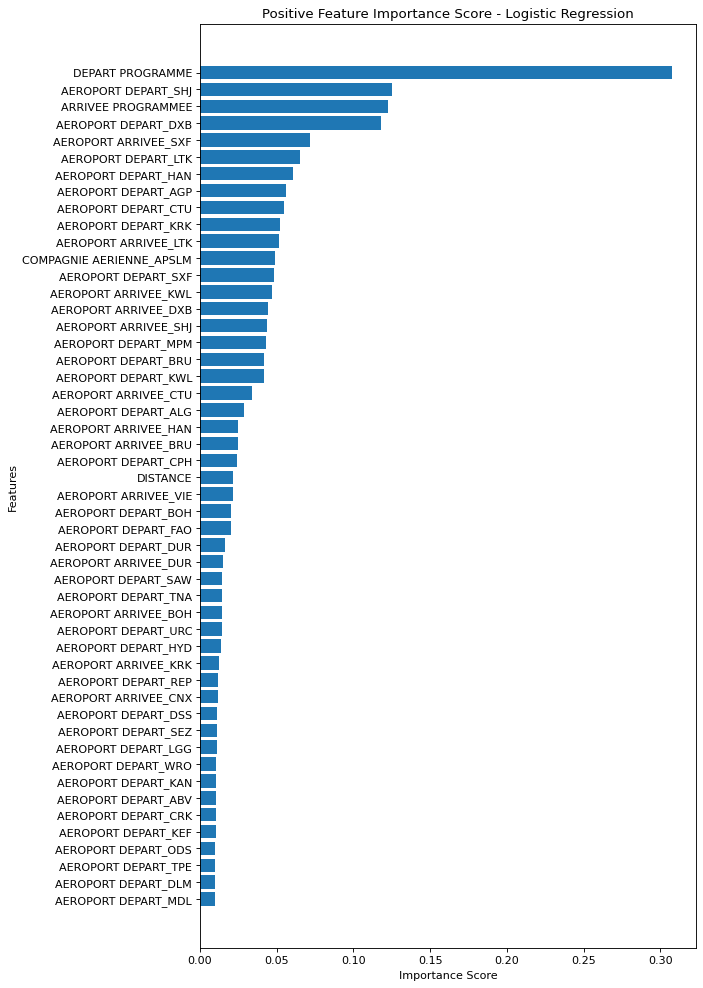

In [147]:
num = 50
ylocs = np.arange(num)

# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

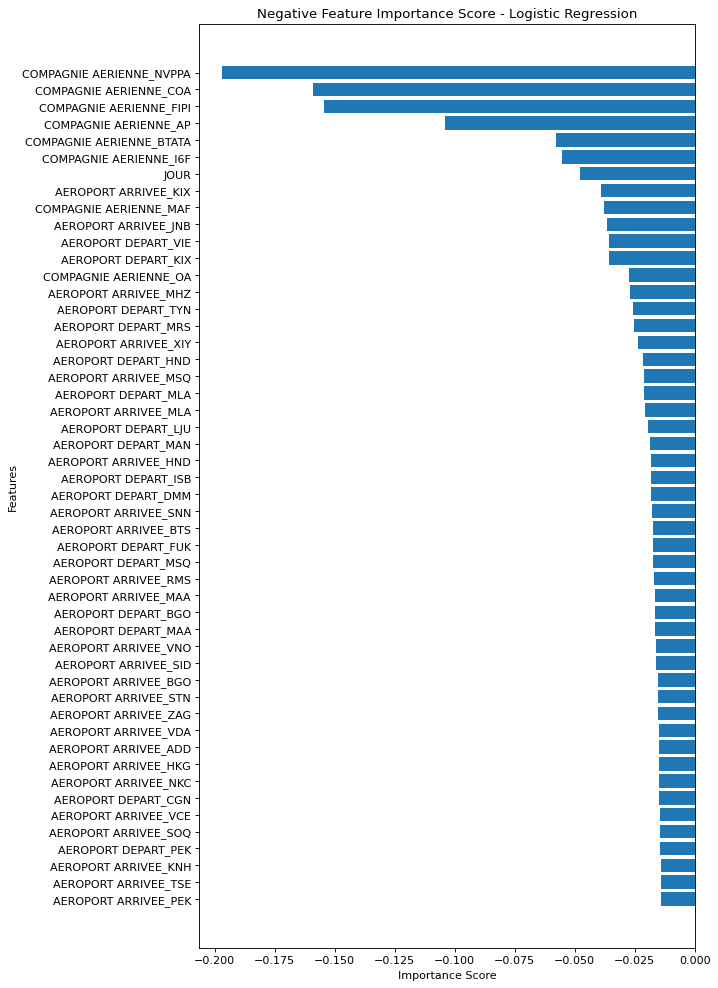

In [148]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

#### Evaluation de performance du modéle : 

In [149]:
pickle.dump(lr, open('best_classifier.pkl', 'wb'),protocol = 4)

In [150]:
import pickle
# load the model
best_model = pickle.load(open('best_classifier.pkl','rb'))

In [152]:
df_test= pd.read_csv('df_test.csv')

#create X and Y matrix
X_test = df_test[col2use].values
y_test = df_test['Dep_retard15'].values

#transform our data matrices
X_test_tf = scaler.transform(X_test)

In [153]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

In [154]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [155]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.650
accuracy:0.608
recall:0.620
precision:0.606
specificity:0.597
prevalence:0.500
 
Validation:
AUC:0.649
accuracy:0.601
recall:0.621
precision:0.246
specificity:0.597
prevalence:0.175
 
Test:
AUC:0.648
accuracy:0.600
recall:0.618
precision:0.244
specificity:0.596
prevalence:0.174
 


Le classificateur de régression logistique a les scores de train/ validation les plus proches

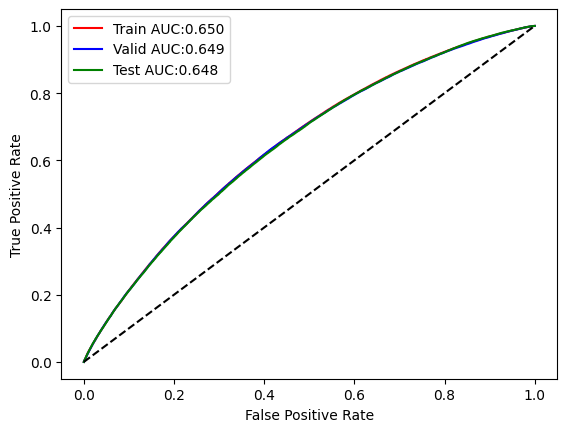

In [157]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()